<h1> Varational Autoencoder for Genotype Imputation <span class="tocSkip"></span></h1>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Dataset" data-toc-modified-id="Dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dataset</a></span><ul class="toc-item"><li><span><a href="#Loading-data" data-toc-modified-id="Loading-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Loading data</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Preprocessing</a></span></li></ul></li><li><span><a href="#Method" data-toc-modified-id="Method-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Method</a></span><ul class="toc-item"><li><span><a href="#Build-model" data-toc-modified-id="Build-model-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Build model</a></span></li><li><span><a href="#Generate-data" data-toc-modified-id="Generate-data-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Generate data</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Plot" data-toc-modified-id="Plot-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Plot</a></span></li></ul></li><li><span><a href="#Save-model" data-toc-modified-id="Save-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Save model</a></span></li></ul></div>

# Introduction

This notebook is a case study of building a SCDA model by using completely convolutional layers with L1 regularization on the weigths, which achieves ~99% imputation accuracy on yeast genotype dataset.

In [1]:
from tensorflow.keras.layers import Input, Dense, Lambda, Reshape, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import sparse_categorical_crossentropy,categorical_crossentropy



In [2]:
# specify a seed for repeating the exact dataset splits
np.random.seed(seed=28213)

# Dataset

## Loading data

In [3]:
input_name = '../data/yeast_genotype_train.txt'
df_ori = pd.read_csv(input_name, sep='\t', index_col=0)
df_ori.shape

(3513, 28220)

In [4]:
df_ori.head()

,33070_chrI_33070_A_T,33147_chrI_33147_G_T,33152_chrI_33152_T_C,33200_chrI_33200_C_T,33293_chrI_33293_A_T,33328_chrI_33328_C_A,33348_chrI_33348_G_C,33403_chrI_33403_C_T,33502_chrI_33502_A_G,33548_chrI_33548_A_C,...,12048853_chrXVI_925593_G_C,12049199_chrXVI_925939_T_C,12049441_chrXVI_926181_C_T,12050613_chrXVI_927353_T_G,12051167_chrXVI_927907_A_C,12051240_chrXVI_927980_A_G,12051367_chrXVI_928107_C_T,12052782_chrXVI_929522_C_T,12052988_chrXVI_929728_A_G,12053130_chrXVI_929870_C_T
SAMID,,,,,,,,,,,,,,,,,,,,,
01_01,1,1,1,1,1,1,1,1,1,1,...,2,2,2,2,2,2,2,2,2,2
01_02,1,1,1,1,1,1,1,1,1,1,...,2,2,2,2,2,2,2,2,2,2
01_03,2,2,2,2,2,2,2,2,2,2,...,1,1,1,1,1,1,1,1,1,1
01_04,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
01_06,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


## Preprocessing

In [5]:
# one hot encode
df_onehot = to_categorical(df_ori)
df_onehot.shape

(3513, 28220, 3)

In [6]:
# split df to train and valid
train_X, valid_X = train_test_split(df_onehot, test_size=0.2)

train_X.shape, valid_X.shape

((2810, 28220, 3), (703, 28220, 3))

### Generar los datos

In [7]:
# Parámetros de entrenamiento
batch_size = 32
epochs = 10

# Generador de datos para Denoising Autoencoder
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, batch_size, x_dataset, missing_perc=0.1, shuffle=True):
        self.batch_size = batch_size
        self.x = x_dataset
        self.missing_perc = missing_perc
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(self.x.shape[0] / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        x_missing = self.x[indexes].copy()

        for i in range(x_missing.shape[0]):
            missing_size = int(self.missing_perc * x_missing.shape[1])
            missing_index = np.random.randint(x_missing.shape[1], size=missing_size)
            x_missing[i, missing_index, :] = [1, 0, 0]  # Ajusta según la estructura de los datos

        return x_missing, self.x[indexes]

    def on_epoch_end(self):
        self.indexes = np.arange(self.x.shape[0])
        if self.shuffle:
            np.random.shuffle(self.indexes)

# Instanciar el DataGenerator
train_generator = DataGenerator(batch_size=batch_size, x_dataset=train_X, missing_perc=0.1)
valid_generator = DataGenerator(batch_size=batch_size, x_dataset=valid_X, missing_perc=0.1)

In [16]:
# Obtener el primer batch para verificar
first_batch_train = train_generator[0]
first_batch_valid = valid_generator[0]

print("Primer batch de entrenamiento:\n", first_batch_train)
print("Primer batch de validación:\n", first_batch_valid)
print("Valores únicos en el primer batch de entrenamiento:", np.unique(first_batch_train))
print("Valores únicos en el primer batch de validación:", np.unique(first_batch_valid))

Primer batch de entrenamiento:
 (array([[[1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        ...,
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]],

       [[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        ...,
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]],

       [[0., 0., 1.],
        [1., 0., 0.],
        [0., 0., 1.],
        ...,
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.]],

       ...,

       [[0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        ...,
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]],

       [[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        ...,
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]],

       [[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        ...,
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]]]), array([[[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
     

# Method

## Build model

In [12]:
from tensorflow.keras.layers import Input, Dense, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
import tensorflow as tf

# Dimensiones
#original_dim = train_X.shape[1]
#latent_dim = 16  # Dimensión del espacio latente
#intermediate_dim = 64
#epsilon_std = 1.0
original_dim = train_X.shape[1]
latent_dim = 16
intermediate_dim = 64
kr = 1e-4  # L1 regularization factor
drop_prec = 0.25
inChannel = 3  # Number of channels in input (3 in this case)
epsilon_std = 1.0
kl_scale = 0.001 

In [17]:
#NO DA ERROR PERO PERDIDA NAN
# Función de muestreo
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch, dim), mean=0., stddev=epsilon_std)
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Modelo Encoder
inputs = Input(shape=(original_dim, 3))
h = Dense(intermediate_dim, activation='relu')(inputs)
h = Flatten()(h)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)
z = Lambda(sampling)([z_mean, z_log_var])

# Modelo Decoder
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim * 3, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)
x_decoded_mean = Reshape((original_dim, 3))(x_decoded_mean)

# Capa personalizada para calcular la pérdida VAE
class VAELossLayer(Layer):
    def call(self, inputs):
        x, x_decoded_mean, z_mean, z_log_var = inputs
        # Pérdida de entropía cruzada binaria
        xent_loss = K.sum(categorical_crossentropy(x, x_decoded_mean), axis=1)  # Solo reducimos en la dimensión 1
        # Pérdida KL
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=1)
        # Suma de las pérdidas
        return xent_loss + kl_loss

    def compute_output_shape(self, input_shape):
        return (input_shape[0],)

# Aplicar la capa personalizada de pérdida
loss_layer = VAELossLayer()([inputs, x_decoded_mean, z_mean, z_log_var])

# Modelo final
vae_final = Model(inputs, loss_layer)

# Compilar el modelo (sin pérdida adicional, ya que la pérdida está en la capa)
# Compilar el modelo con una pérdida dummy
vae_final.compile(loss='categorical_crossentropy', 
                    optimizer='adam',
                    metrics=['accuracy'])

vae_final.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 28220, 3)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 28220, 64) │        256 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 1806080)   │          0 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 16)        │ 28,897,296 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 16)        │ 28,897,296 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 16)        │          0 │ dense_14[0][0],   │
│                     │                   │            │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 64)        │      1,088 │ lambda_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 84660)     │  5,502,900 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 28220, 3)  │          0 │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_loss_layer_3    │ (None, 28220, 3)  │          0 │ input_layer_3[0]… │
│ (VAELossLayer)      │                   │            │ reshape_3[0][0],  │
│                     │                   │            │ dense_14[0][0],   │
│                     │                   │            │ dense_15[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 63,298,836 (241.47 MB)

 Trainable params: 63,298,836 (241.47 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Dense, Lambda, Reshape, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import tensorflow as tf

original_dim = train_X.shape[1]
latent_dim = 16
intermediate_dim = 64
kr = 1e-4  # L1 regularization factor
drop_prec = 0.25
inChannel = 3  # Number of channels in input (3 in this case)
epsilon_std = 1.0
kl_scale = 0.001 


# Función de muestreo
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Modelo Encoder
inputs = Input(shape=(original_dim, inChannel))
x = Conv1D(32, 5, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l1(kr))(inputs)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(drop_prec)(x)

x = Conv1D(64, 5, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l1(kr))(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(drop_prec)(x)

x = Conv1D(128, 5, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l1(kr))(x)

# Flatten and latent space
x = Flatten()(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)
z = Lambda(sampling)([z_mean, z_log_var])

# Calcular la nueva forma después de Flatten para Reshape
reshape_dim = original_dim // 4  # Recalcular reshape_dim para que se ajuste al tamaño final deseado

# Decoder
decoder_h = Dense(128 * reshape_dim, activation='relu')
h_decoded = decoder_h(z)
h_decoded = Reshape((reshape_dim, 128))(h_decoded)

h_decoded = Conv1D(64, 5, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l1(kr))(h_decoded)
h_decoded = UpSampling1D(size=2)(h_decoded)  # Ajustar el tamaño de upsampling
h_decoded = Dropout(drop_prec)(h_decoded)

h_decoded = Conv1D(32, 5, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l1(kr))(h_decoded)
h_decoded = UpSampling1D(size=2)(h_decoded)  # Otro Upsampling para restaurar completamente la longitud
h_decoded = Dropout(drop_prec)(h_decoded)

# Ajustar longitud final si es necesario
x_decoded_mean = Conv1D(inChannel, 5, padding='same', activation='sigmoid')(h_decoded)

# Si la longitud no coincide, agregamos una capa adicional para ajustar
if K.int_shape(x_decoded_mean)[1] != original_dim:
    x_decoded_mean = Conv1D(inChannel, 1, activation='sigmoid')(x_decoded_mean)

# Modelo VAE
vae = Model(inputs, x_decoded_mean)

# Pérdida VAE
class VAELossLayer(Layer):
    def call(self, inputs):
        x, x_decoded_mean, z_mean, z_log_var = inputs
        # Pérdida de entropía cruzada categórica
        xent_loss = K.sum(categorical_crossentropy(x, x_decoded_mean), axis=1)
        # Pérdida KL con escalado para evitar problemas numéricos
        kl_loss = kl_scale * -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=1)
        
        # Comprobar si hay NaN en la pérdida y sustituir por cero
        xent_loss = tf.where(tf.math.is_nan(xent_loss), tf.zeros_like(xent_loss), xent_loss)
        kl_loss = tf.where(tf.math.is_nan(kl_loss), tf.zeros_like(kl_loss), kl_loss)

        # Suma de las pérdidas
        total_loss = xent_loss + kl_loss
        return total_loss

    def compute_output_shape(self, input_shape):
        return (input_shape[0],)

# Aplicar la capa personalizada de pérdida
loss_layer = VAELossLayer()([inputs, x_decoded_mean, z_mean, z_log_var])

# Modelo final
vae = Model(inputs, loss_layer)

# Compilar el modelo (sin pérdida adicional, ya que la pérdida está en la capa)
vae.compile(optimizer='rmsprop', loss=lambda y_true, y_pred: y_pred)

vae.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 28220, 3)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 28220, 32) │        512 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 14110, 32) │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 14110, 32) │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 14110, 64) │     10,304 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 7055, 64)  │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 7055, 64)  │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 7055, 128) │     41,088 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 903040)    │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 16)        │ 14,448,656 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 16)        │ 14,448,656 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 16)        │          0 │ dense_5[0][0],    │
│                     │                   │            │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 903040)    │ 15,351,680 │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 7055, 128) │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 7055, 64)  │     41,024 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d       │ (None, 14110, 64) │          0 │ conv1d_3[0][0]    │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 14110, 64) │          0 │ up_sampling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 14110, 32) │     10,272 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d_1     │ (None, 28220, 32) │          0 │ conv1d_4[0][0]    │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 28220, 32) │          0 │ up_sampling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 28220, 3)  │        483 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_loss_layer_1    │ (None, 28220, 3)  │          0 │ input_layer_1[0]

 Total params: 44,352,675 (169.19 MB)

 Trainable params: 44,352,675 (169.19 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Dropout, Dense, Lambda, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l1

# Parámetros
feature_size = train_X.shape[1]  # tamaño de la secuencia de entrada
inChannel = 3       # canal de entrada
kr = 0.001          # regularización L1
drop_prec = 0.5     # tasa de dropout
latent_dim = 16     # tamaño del espacio latente

# Encoder
inputs = Input(shape=(feature_size, inChannel))
x = Conv1D(32, 5, padding='same', activation='relu', kernel_regularizer=l1(kr))(inputs)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(drop_prec)(x)

x = Conv1D(64, 5, padding='same', activation='relu', kernel_regularizer=l1(kr))(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(drop_prec)(x)

x = Conv1D(128, 5, padding='same', activation='relu', kernel_regularizer=l1(kr))(x)
shape_before_flattening = K.int_shape(x)  # guardamos la forma antes del flattening
x = Flatten()(x)

# Latent space: mean and log variance
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

# Sampling layer
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

# Decoder
decoder_input = Input(K.int_shape(z)[1:])
x = Dense(np.prod(shape_before_flattening[1:]))(decoder_input)
x = Reshape(shape_before_flattening[1:])(x)

x = Conv1D(128, 5, padding='same', activation='relu', kernel_regularizer=l1(kr))(x)

x = Conv1D(64, 5, padding='same', activation='relu', kernel_regularizer=l1(kr))(x)
x = UpSampling1D(2)(x)
x = Dropout(drop_prec)(x)

x = Conv1D(32, 5, padding='same', activation='relu', kernel_regularizer=l1(kr))(x)
x = UpSampling1D(2)(x)
x = Dropout(drop_prec)(x)

outputs = Conv1D(inChannel, 5, activation='sigmoid', padding='same')(x)  # Sigmoid para salida continua

decoder = Model(decoder_input, outputs)
z_decoded = decoder(z)

# Loss function
class CustomVAEModel(Model):
    def vae_loss(self, inputs, z_decoded):
        # Reconstruction loss
        reconstruction_loss = binary_crossentropy(K.flatten(inputs), K.flatten(z_decoded))
        reconstruction_loss *= feature_size * inChannel

        # KL divergence
        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5

        return K.mean(reconstruction_loss + kl_loss)

    def call(self, inputs):
        z_decoded = decoder(z)
        loss = self.vae_loss(inputs, z_decoded)
        self.add_loss(loss)
        return z_decoded

vae = CustomVAEModel(inputs, z_decoded)

# Compilar el modelo
vae.compile(optimizer='adam')
vae.summary()

Model: "custom_vae_model_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 28220, 3)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_20 (Conv1D)  │ (None, 28220, 32) │        512 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 14110, 32) │          0 │ conv1d_20[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 14110, 32) │          0 │ max_pooling1d_6[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_21 (Conv1D)  │ (None, 14110, 64) │     10,304 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 7055, 64)  │          0 │ conv1d_21[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 7055, 64)  │          0 │ max_pooling1d_7[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_22 (Conv1D)  │ (None, 7055, 128) │     41,088 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 903040)    │          0 │ conv1d_22[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 16)        │ 14,448,656 │ flatten_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 16)        │ 14,448,656 │ flatten_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_6 (Lambda)   │ (None, 16)        │          0 │ dense_24[0][0],   │
│                     │                   │            │ dense_25[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_7        │ (None, 28220, 3)  │ 15,485,507 │ lambda_6[0][0]    │
│ (Functional)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 44,434,723 (169.51 MB)

 Trainable params: 44,434,723 (169.51 MB)

 Non-trainable params: 0 (0.00 B)

## Training

In [23]:
# Entrenamiento del VAE usando el DataGenerator

vae_train =  vae.fit(
    train_generator,
    epochs=epochs,
    verbose=1,
    validation_data=valid_generator
)

Epoch 1/10


ValueError: Exception encountered when calling CustomVAEModel.call().

[1mTried to convert 'tensor' to a tensor and failed. Error: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```
[0m

Arguments received by CustomVAEModel.call():
  • inputs=tf.Tensor(shape=(None, 28220, 3), dtype=float64)

## Plot

/var/folders/rx/6l7qymcs6md_xt6rzyf70x040000gn/T/ipykernel_41605/4018524515.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(range(len(loss)), loss, 'b', label='Training loss', color="black")


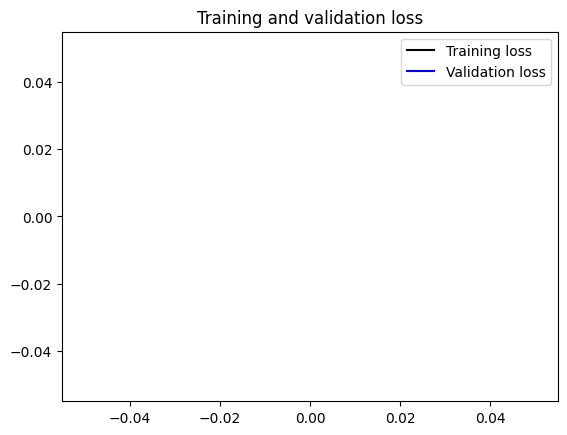

In [ ]:
# Plot loss curve on validation data
loss = vae_train.history['loss']
val_loss = vae_train.history['val_loss']

plt.figure()
plt.plot(range(len(loss)), loss, 'b', label='Training loss', color="black")
plt.plot(range(len(val_loss)), val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()



In [ ]:
# function modified -- key "acc" did not exist. the correct key is 
# plot accuracy curve on validation data
print(vae_train.history.keys())
acc = vae_train.history['accuracy'] #initially the key was acc
val_acc = vae_train.history['val_accuracy']#initially the key was val_ acc
plt.figure()
plt.plot(range(len(acc)), acc, 'b', label='Training acc', color="black")
plt.plot(range(len(val_acc)), val_acc, 'b', label='Validation acc',color="blue")
plt.title('Training and validation acc')
plt.legend()
plt.show()

dict_keys(['loss', 'val_loss'])


KeyError: 'accuracy'

### ADDED: See numerical final results

In [ ]:
print("Final Training Loss:", loss[-1])
print("Final Validation Loss:", val_loss[-1])
print("Final Training Accuracy:", acc[-1])
print("Final Validation Accuracy:", val_acc[-1])

Final Training Loss: 0.017660541459918022
Final Validation Loss: 0.014919193461537361
Final Training Accuracy: 0.998394250869751
Final Validation Accuracy: 0.9994722008705139


# Save model

In [ ]:
# Guardar el modelo
vae.save('../models/VAE_yeast.keras')